# EDA + XGBoost with Robustness Checks

This notebook combines the EDA pipeline with XGBoost model training and performs robustness checks by varying:
- Early window size: 3, 4, 5 actions
- Label threshold: different weighted score thresholds (3, 4, 5)
- Last action day threshold: different day thresholds (5, 10, 15)

### Table of contents
- [1. Imports](#1-imports)
- [2. Data Processing Function](#2-data-processing-function)
- [3. XGBoost Model Training Function](#3-xgboost-model-training-function)
- [4. Robustness Checks](#4-robustness-checks)
- [5. Results Summary](#5-results-summary)


### 1. Imports


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    classification_report, confusion_matrix
)

# XGBoost
import xgboost as xgb

print("✓ All packages loaded successfully")


✓ All packages loaded successfully


### 2. Import Processing Function

We'll import the data processing function that encapsulates the entire EDA pipeline.


In [2]:
# Import the processing function
from robustness_processing import process_data_for_robustness

print("✓ Processing function imported")


✓ Processing function imported


### 3. XGBoost Model Training Function


In [ ]:
def train_xgboost_model(df_user, config_name="default"):
    
    print(f"\n{'='*60}")
    print(f"Training XGBoost model for: {config_name}")
    print(f"{'='*60}")
    
    y = df_user["y_active"].astype(int)
    drop_cols = [c for c in ["y_active", "userId"] if c in df_user.columns]
    X = df_user.drop(columns=drop_cols, errors="ignore")
    
    # Train/validation/test split
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train_full, y_train_full, test_size=0.20, random_state=42, stratify=y_train_full
    )
    
    # Preprocessing
    cat_cols = list(X_train.select_dtypes(include=["object", "category", "string", "bool"]).columns)
    for c in X_train.select_dtypes(include=["int16", "int32", "int64", "Int8", "Int16", "Int32", "Int64", "uint8", "uint16"]).columns:
        if X_train[c].nunique(dropna=True) <= 20 and c not in cat_cols:
            cat_cols.append(c)
    
    num_cols = [c for c in X_train.columns if c not in cat_cols]
    
    try:
        oh_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, min_frequency=0.01)
    except TypeError:
        oh_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    
    pre = ColumnTransformer(
        transformers=[
            ("num", SimpleImputer(strategy="median"), num_cols),
            ("cat", Pipeline(steps=[
                ("impute", SimpleImputer(strategy="most_frequent")),
                ("oh", oh_encoder)
            ]), cat_cols),
        ],
        remainder="drop"
    )
    
    X_train_t = pre.fit_transform(X_train, y_train)
    X_valid_t = pre.transform(X_valid)
    X_test_t = pre.transform(X_test)
    
    # Handle class imbalance
    pos = y_train.sum()
    neg = len(y_train) - pos
    scale_pos_weight = (neg / max(pos, 1))
    
    # Base parameters
    base_params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "scale_pos_weight": scale_pos_weight,
        "seed": 42,
        "n_jobs": -1,
    }
    
    # Simplified hyperparameters
    params = {
        **base_params,
        "learning_rate": 0.05,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "reg_alpha": 0.5,
        "reg_lambda": 2.0,
        "min_child_weight": 3,
        "gamma": 0.2,
    }
    
    # Train model
    dtrain = xgb.DMatrix(X_train_t, label=y_train.values)
    dvalid = xgb.DMatrix(X_valid_t, label=y_valid.values)
    dtest = xgb.DMatrix(X_test_t, label=y_test.values)
    
    evals = [(dtrain, "train"), (dvalid, "valid")]
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=200,
        evals=evals,
        early_stopping_rounds=30,
        verbose_eval=False,
    )
    
    # Evaluate
    proba_test = booster.predict(dtest)
    pred_test = (proba_test >= 0.5).astype(int)
    
    roc_auc = roc_auc_score(y_test, proba_test)
    pr_auc = average_precision_score(y_test, proba_test)
    f1 = f1_score(y_test, pred_test)
    
    results = {
        'config_name': config_name,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'f1_score': f1,
        'n_users': len(df_user),
        'n_active': y.sum(),
        'pct_active': y.mean(),
    }
    
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return results

print("✓ XGBoost training function defined")


✓ XGBoost training function defined


### 4. Robustness Checks

Now we'll run the data processing and model training for all parameter combinations.


In [4]:
# Define parameter combinations for robustness checks
early_window_sizes = [3, 4, 5]
label_thresholds = [3, 4, 5]
last_action_days = [5, 10, 15]

# Store all results
all_results = []
all_datasets = {}

print(f"\n{'='*80}")
print(f"ROBUSTNESS CHECKS")
print(f"Total combinations: {len(early_window_sizes) * len(label_thresholds) * len(last_action_days)}")
print(f"{'='*80}")

for early_window in early_window_sizes:
    for label_threshold in label_thresholds:
        for last_action_day in last_action_days:
            
            config_name = f"win{early_window}_thresh{label_threshold}_day{last_action_day}"
            
            try:
                # Process data
                df_user = process_data_for_robustness(
                    early_window_size=early_window,
                    label_threshold=label_threshold,
                    last_action_day_threshold=last_action_day
                )
                
                # Save dataset
                filename = f"../data/user_level_data_robustness_checks_{config_name}.csv"
                df_user.to_csv(filename, index=False)
                all_datasets[config_name] = df_user
                print(f"✓ Saved dataset: {filename}")
                
                # Train model
                results = train_xgboost_model(df_user, config_name=config_name)
                all_results.append(results)
                
            except Exception as e:
                print(f"\n✗ Error processing {config_name}: {e}")
                import traceback
                traceback.print_exc()
                continue

print(f"\n{'='*80}")
print(f"ROBUSTNESS CHECKS COMPLETE")
print(f"{'='*80}")



ROBUSTNESS CHECKS
Total combinations: 27

Processing with: early_window=3, label_threshold=3, last_action_day=5
Final user-level dataset shape: (20011, 31)
Target distribution:
y_active
0    0.584878
1    0.415122
Name: proportion, dtype: float64
✓ Saved dataset: ../data/user_level_data_robustness_checks_win3_thresh3_day5.csv

Training XGBoost model for: win3_thresh3_day5
ROC AUC: 0.9695
PR AUC: 0.9409
F1 Score: 0.9280

Processing with: early_window=3, label_threshold=3, last_action_day=10
Final user-level dataset shape: (20011, 31)
Target distribution:
y_active
0    0.648693
1    0.351307
Name: proportion, dtype: float64
✓ Saved dataset: ../data/user_level_data_robustness_checks_win3_thresh3_day10.csv

Training XGBoost model for: win3_thresh3_day10
ROC AUC: 0.9410
PR AUC: 0.8763
F1 Score: 0.8448

Processing with: early_window=3, label_threshold=3, last_action_day=15
Final user-level dataset shape: (20011, 31)
Target distribution:
y_active
0    0.70871
1    0.29129
Name: proportion, d

In [ ]:
# Create results dataframe
results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("ROBUSTNESS CHECK RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))

# Save results
results_df.to_csv("../robustness_check/robustness_check_results.csv", index=False)
print("\n✓ Results saved to: ../robustness_check/robustness_check_results.csv")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Mean ROC AUC: {results_df['roc_auc'].mean():.4f} (std: {results_df['roc_auc'].std():.4f})")
print(f"Mean PR AUC: {results_df['pr_auc'].mean():.4f} (std: {results_df['pr_auc'].std():.4f})")
print(f"Mean F1 Score: {results_df['f1_score'].mean():.4f} (std: {results_df['f1_score'].std():.4f})")

# Best configuration
best_config = results_df.loc[results_df['roc_auc'].idxmax()]
print(f"\nBest configuration (by ROC AUC): {best_config['config_name']}")
print(f"  ROC AUC: {best_config['roc_auc']:.4f}")
print(f"  PR AUC: {best_config['pr_auc']:.4f}")
print(f"  F1 Score: {best_config['f1_score']:.4f}")



ROBUSTNESS CHECK RESULTS SUMMARY
       config_name  roc_auc   pr_auc  f1_score  n_users  n_active  pct_active
 win3_thresh3_day5 0.969529 0.940893  0.927986    20011      8307    0.415122
win3_thresh3_day10 0.940953 0.876277  0.844754    20011      7030    0.351307
win3_thresh3_day15 0.924798 0.807582  0.760979    20011      5829    0.291290
 win3_thresh4_day5 0.960796 0.902563  0.862706    20011      6735    0.336565
win3_thresh4_day10 0.939726 0.829598  0.797014    20011      5781    0.288891
win3_thresh4_day15 0.920168 0.747895  0.717751    20011      4847    0.242217
 win3_thresh5_day5 0.961845 0.879279  0.823944    20011      5471    0.273400
win3_thresh5_day10 0.936784 0.779534  0.746689    20011      4760    0.237869
win3_thresh5_day15 0.923067 0.708757  0.669655    20011      4036    0.201689
 win4_thresh3_day5 0.973430 0.951086  0.925884    20011      8212    0.410374
win4_thresh3_day10 0.945504 0.878821  0.843625    20011      6957    0.347659
win4_thresh3_day15 0.928643 0.

### 6. Visualization of Results


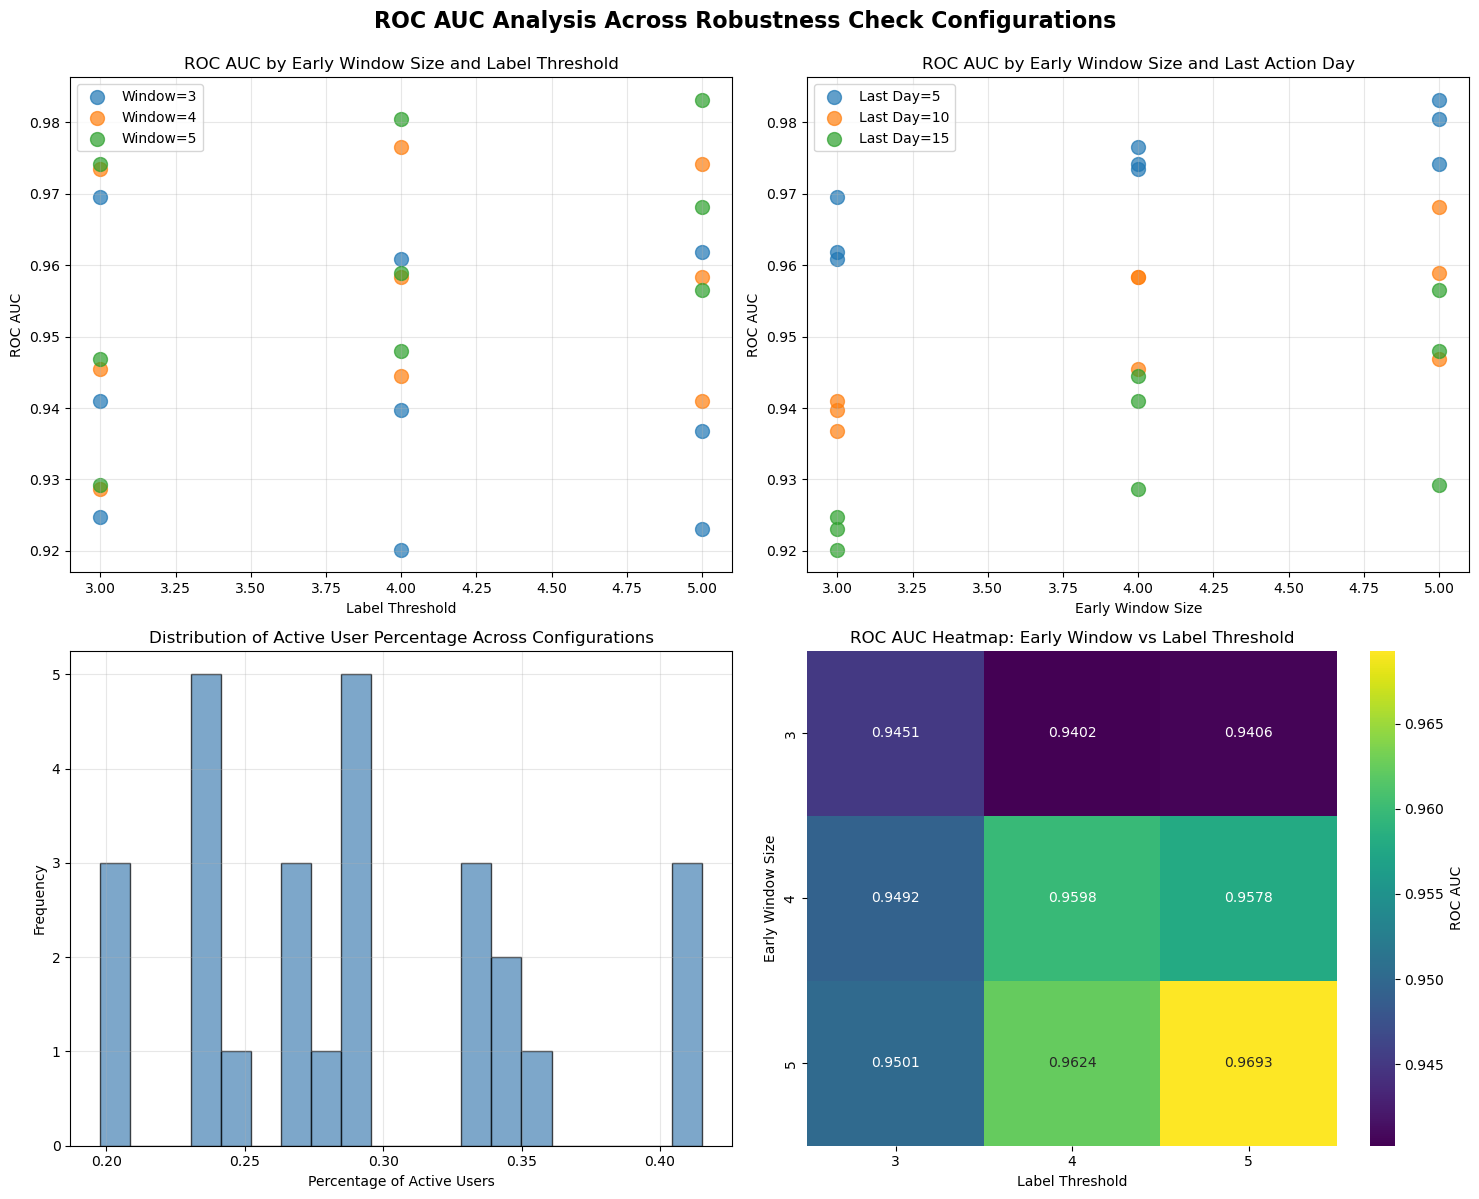

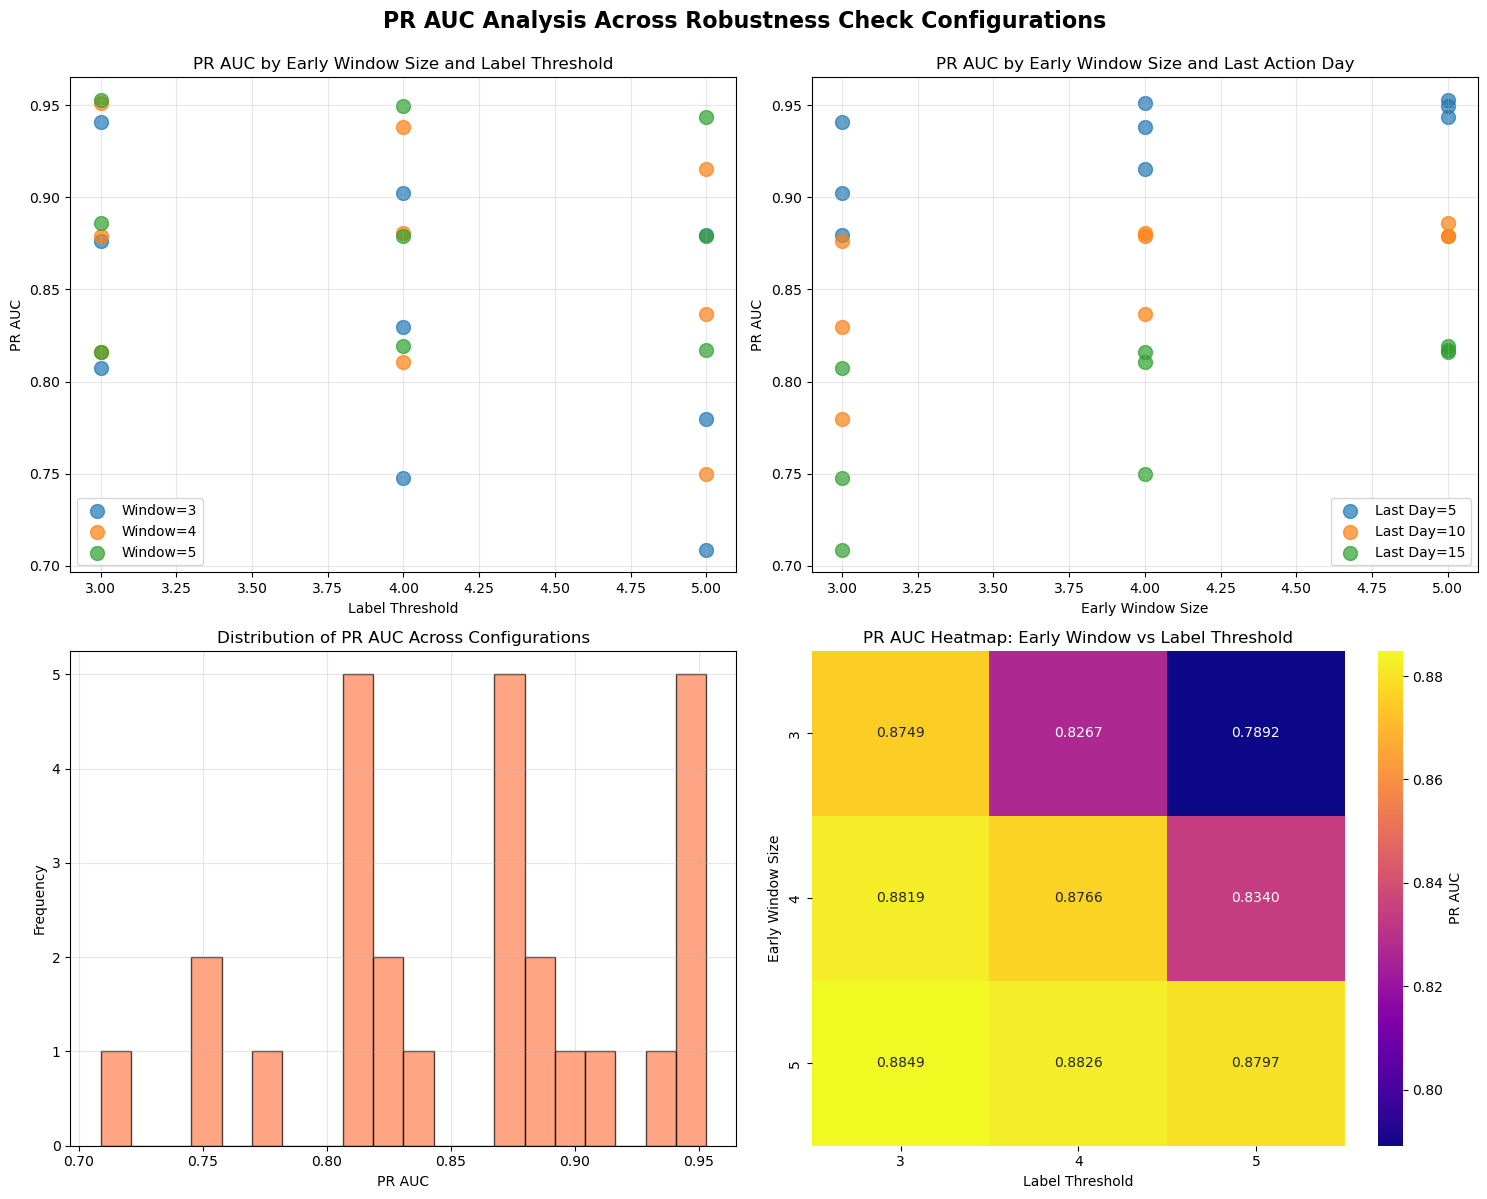

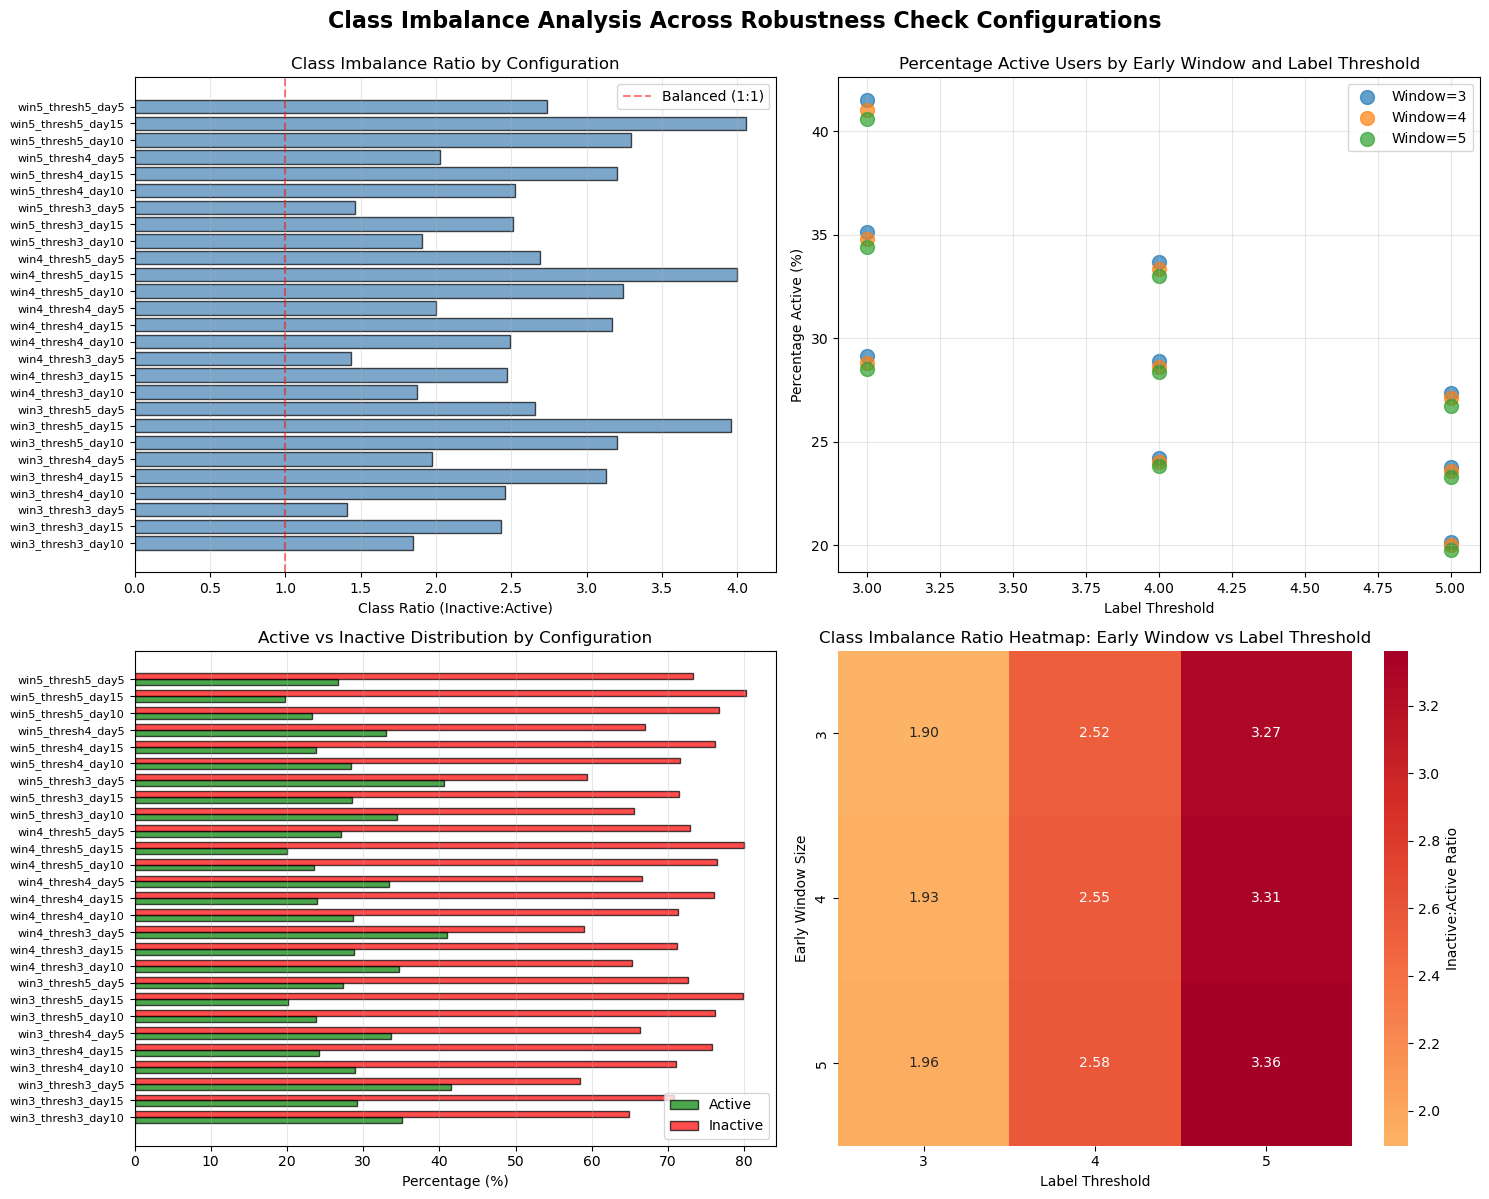


CLASS IMBALANCE COMPARISON TABLE
     Configuration  Total Users  Active Users  Inactive Users  Active %  Inactive %  Ratio (Inactive:Active)
win3_thresh3_day10        20011          7030           12981     35.13       64.87                     1.85
win3_thresh3_day15        20011          5829           14182     29.13       70.87                     2.43
 win3_thresh3_day5        20011          8307           11704     41.51       58.49                     1.41
win3_thresh4_day10        20011          5781           14230     28.89       71.11                     2.46
win3_thresh4_day15        20011          4847           15164     24.22       75.78                     3.13
 win3_thresh4_day5        20011          6735           13276     33.66       66.34                     1.97
win3_thresh5_day10        20011          4760           15251     23.79       76.21                     3.20
win3_thresh5_day15        20011          4036           15975     20.17       79.83           

In [ ]:
# Create visualizations
if len(results_df) > 0:
    # Extract parameters from config names
    results_df['early_window'] = results_df['config_name'].str.extract(r'win(\d+)').astype(int)
    results_df['label_threshold'] = results_df['config_name'].str.extract(r'thresh(\d+)').astype(int)
    results_df['last_action_day'] = results_df['config_name'].str.extract(r'day(\d+)').astype(int)
    
    # Calculate inactive counts and ratios
    results_df['n_inactive'] = results_df['n_users'] - results_df['n_active']
    results_df['pct_inactive'] = 1 - results_df['pct_active']
    results_df['class_ratio'] = results_df['n_inactive'] / results_df['n_active']
    

    fig1, axes1 = plt.subplots(2, 2, figsize=(15, 12))

    ax1 = axes1[0, 0]
    for win in sorted(results_df['early_window'].unique()):
        subset = results_df[results_df['early_window'] == win]
        ax1.scatter(subset['label_threshold'], subset['roc_auc'], 
                   label=f'Window={win}', alpha=0.7, s=100)
    ax1.set_xlabel('Label Threshold')
    ax1.set_ylabel('ROC AUC')
    ax1.set_title('ROC AUC by Early Window Size and Label Threshold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # ROC AUC by last action day
    ax2 = axes1[0, 1]
    for day in sorted(results_df['last_action_day'].unique()):
        subset = results_df[results_df['last_action_day'] == day]
        ax2.scatter(subset['early_window'], subset['roc_auc'], 
                   label=f'Last Day={day}', alpha=0.7, s=100)
    ax2.set_xlabel('Early Window Size')
    ax2.set_ylabel('ROC AUC')
    ax2.set_title('ROC AUC by Early Window Size and Last Action Day')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Distribution of active users
    ax3 = axes1[1, 0]
    ax3.hist(results_df['pct_active'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
    ax3.set_xlabel('Percentage of Active Users')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Active User Percentage Across Configurations')
    ax3.grid(True, alpha=0.3)
    
    # Heatmap of ROC AUC
    ax4 = axes1[1, 1]
    pivot_roc = results_df.pivot_table(
        values='roc_auc',
        index='early_window',
        columns='label_threshold',
        aggfunc='mean'
    )
    sns.heatmap(pivot_roc, annot=True, fmt='.4f', cmap='viridis', ax=ax4, cbar_kws={'label': 'ROC AUC'})
    ax4.set_title('ROC AUC Heatmap: Early Window vs Label Threshold')
    ax4.set_xlabel('Label Threshold')
    ax4.set_ylabel('Early Window Size')
    
    plt.suptitle('ROC AUC Analysis Across Robustness Check Configurations', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('../data/robustness_check_roc_auc_visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    fig2, axes2 = plt.subplots(2, 2, figsize=(15, 12))
    
    # PR AUC by early window
    ax1 = axes2[0, 0]
    for win in sorted(results_df['early_window'].unique()):
        subset = results_df[results_df['early_window'] == win]
        ax1.scatter(subset['label_threshold'], subset['pr_auc'], 
                   label=f'Window={win}', alpha=0.7, s=100)
    ax1.set_xlabel('Label Threshold')
    ax1.set_ylabel('PR AUC')
    ax1.set_title('PR AUC by Early Window Size and Label Threshold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # PR AUC by last action day
    ax2 = axes2[0, 1]
    for day in sorted(results_df['last_action_day'].unique()):
        subset = results_df[results_df['last_action_day'] == day]
        ax2.scatter(subset['early_window'], subset['pr_auc'], 
                   label=f'Last Day={day}', alpha=0.7, s=100)
    ax2.set_xlabel('Early Window Size')
    ax2.set_ylabel('PR AUC')
    ax2.set_title('PR AUC by Early Window Size and Last Action Day')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Distribution of PR AUC
    ax3 = axes2[1, 0]
    ax3.hist(results_df['pr_auc'], bins=20, edgecolor='black', alpha=0.7, color='coral')
    ax3.set_xlabel('PR AUC')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of PR AUC Across Configurations')
    ax3.grid(True, alpha=0.3)
    
    # Heatmap of PR AUC
    ax4 = axes2[1, 1]
    pivot_pr = results_df.pivot_table(
        values='pr_auc',
        index='early_window',
        columns='label_threshold',
        aggfunc='mean'
    )
    sns.heatmap(pivot_pr, annot=True, fmt='.4f', cmap='plasma', ax=ax4, cbar_kws={'label': 'PR AUC'})
    ax4.set_title('PR AUC Heatmap: Early Window vs Label Threshold')
    ax4.set_xlabel('Label Threshold')
    ax4.set_ylabel('Early Window Size')
    
    plt.suptitle('PR AUC Analysis Across Robustness Check Configurations', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('../data/robustness_check_pr_auc_visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()

    fig3, axes3 = plt.subplots(2, 2, figsize=(15, 12))
    
    # Class ratio by configuration
    ax1 = axes3[0, 0]
    results_df_sorted = results_df.sort_values('config_name')
    ax1.barh(range(len(results_df_sorted)), results_df_sorted['class_ratio'], 
             color='steelblue', alpha=0.7, edgecolor='black')
    ax1.set_yticks(range(len(results_df_sorted)))
    ax1.set_yticklabels(results_df_sorted['config_name'], fontsize=8)
    ax1.set_xlabel('Class Ratio (Inactive:Active)')
    ax1.set_title('Class Imbalance Ratio by Configuration')
    ax1.axvline(x=1, color='red', linestyle='--', alpha=0.5, label='Balanced (1:1)')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Percentage active by early window
    ax2 = axes3[0, 1]
    for win in sorted(results_df['early_window'].unique()):
        subset = results_df[results_df['early_window'] == win]
        ax2.scatter(subset['label_threshold'], subset['pct_active'] * 100, 
                   label=f'Window={win}', alpha=0.7, s=100)
    ax2.set_xlabel('Label Threshold')
    ax2.set_ylabel('Percentage Active (%)')
    ax2.set_title('Percentage Active Users by Early Window and Label Threshold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Class distribution comparison
    ax3 = axes3[1, 0]
    x_pos = np.arange(len(results_df_sorted))
    width = 0.35
    ax3.barh(x_pos - width/2, results_df_sorted['pct_active'] * 100, width, 
             label='Active', color='green', alpha=0.7, edgecolor='black')
    ax3.barh(x_pos + width/2, results_df_sorted['pct_inactive'] * 100, width, 
             label='Inactive', color='red', alpha=0.7, edgecolor='black')
    ax3.set_yticks(x_pos)
    ax3.set_yticklabels(results_df_sorted['config_name'], fontsize=8)
    ax3.set_xlabel('Percentage (%)')
    ax3.set_title('Active vs Inactive Distribution by Configuration')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Heatmap of class ratio
    ax4 = axes3[1, 1]
    pivot_ratio = results_df.pivot_table(
        values='class_ratio',
        index='early_window',
        columns='label_threshold',
        aggfunc='mean'
    )
    sns.heatmap(pivot_ratio, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=ax4, 
                cbar_kws={'label': 'Inactive:Active Ratio'}, center=1.0)
    ax4.set_title('Class Imbalance Ratio Heatmap: Early Window vs Label Threshold')
    ax4.set_xlabel('Label Threshold')
    ax4.set_ylabel('Early Window Size')
    
    plt.suptitle('Class Imbalance Analysis Across Robustness Check Configurations', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('../data/robustness_check_class_imbalance_visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()
    

    print("\n" + "="*100)
    print("CLASS IMBALANCE COMPARISON TABLE")
    print("="*100)
    
    # Create a detailed table
    imbalance_table = results_df[['config_name', 'n_users', 'n_active', 'n_inactive', 
                                   'pct_active', 'pct_inactive', 'class_ratio']].copy()
    imbalance_table['pct_active'] = (imbalance_table['pct_active'] * 100).round(2)
    imbalance_table['pct_inactive'] = (imbalance_table['pct_inactive'] * 100).round(2)
    imbalance_table['class_ratio'] = imbalance_table['class_ratio'].round(2)
    imbalance_table = imbalance_table.sort_values('config_name')
    
    # Rename columns for display
    imbalance_table_display = imbalance_table.rename(columns={
        'config_name': 'Configuration',
        'n_users': 'Total Users',
        'n_active': 'Active Users',
        'n_inactive': 'Inactive Users',
        'pct_active': 'Active %',
        'pct_inactive': 'Inactive %',
        'class_ratio': 'Ratio (Inactive:Active)'
    })
    
    print(imbalance_table_display.to_string(index=False))
    
    # Save table
    imbalance_table.to_csv('../data/robustness_check_class_imbalance_table.csv', index=False)
    print("\n✓ Class imbalance table saved to: ../data/robustness_check_class_imbalance_table.csv")
    
    # Summary statistics
    print("\n" + "="*100)
    print("CLASS IMBALANCE SUMMARY STATISTICS")
    print("="*100)
    print(f"Mean Active %: {results_df['pct_active'].mean()*100:.2f}% (std: {results_df['pct_active'].std()*100:.2f}%)")
    print(f"Mean Inactive %: {results_df['pct_inactive'].mean()*100:.2f}% (std: {results_df['pct_inactive'].std()*100:.2f}%)")
    print(f"Mean Class Ratio: {results_df['class_ratio'].mean():.2f} (std: {results_df['class_ratio'].std():.2f})")
    print(f"Min Active %: {results_df['pct_active'].min()*100:.2f}%")
    print(f"Max Active %: {results_df['pct_active'].max()*100:.2f}%")
    print(f"Min Class Ratio: {results_df['class_ratio'].min():.2f}")
    print(f"Max Class Ratio: {results_df['class_ratio'].max():.2f}")
    
    print("\n✓ All visualizations saved:")
    print("  - ROC AUC: ../robustness_check/robustness_check_roc_auc_visualizations.png")
    print("  - PR AUC: ../robustness_check/robustness_check_pr_auc_visualizations.png")
    print("  - Class Imbalance: ../robustness_check/robustness_check_class_imbalance_visualizations.png")
